In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import pandas as pd
import os
import sys
import math
import itertools as it
from scipy import io, special
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

sys.path.append(os.path.join(os.path.dirname(os.getcwd())))
from seq import ngram, model, utils
from flow import Paths
from plot import nb, ebar

Folder, _, _, Subjects = Paths.ExpData(fig_subfolder = 'chunk_models')
ext = '.pdf'
folder_tables = os.environ.get('HOME') + '/_pubs/seq_plos_cb/tables/'

[(3, 1, 4, 2), (2, 4, 1, 3), (4, 2, 3, 1), (1, 2, 4, 3), (1, 3, 2, 4), (1, 4, 2, 3), (1, 4, 3, 2), (2, 1, 3, 4), (2, 3, 1, 4), (2, 3, 4, 1), (3, 2, 1, 4), (3, 4, 2, 1), (4, 1, 2, 3), (4, 3, 1, 2)]

In [4]:
# load sequences from th experiment
Seq = pd.read_csv(os.path.join(Folder['SourceData'], 'sequences_individual.tsv'))
S = utils.seq_set(Seq) # convert a python list to a set of immutable tuples
print(S)

[(3, 1, 4, 2), (2, 4, 1, 3), (1, 2, 3, 4), (4, 3, 1, 2), (4, 2, 1, 3), (1, 4, 2, 3), (1, 3, 4, 2), (4, 1, 3, 2), (4, 2, 3, 1), (1, 3, 2, 4), (1, 2, 4, 3), (4, 1, 2, 3), (1, 4, 3, 2), (4, 3, 2, 1)]


In [5]:
# save indiviudal sequences as latex table for the SI

SI = pd.DataFrame({'Sequence': S})
# file_latex = os.path.join(folder_tables,'seqs_.tex')
# with open(file_latex,'w') as tf:
#      tf.write(SI.to_latex(index=False))

In [6]:
# 12 reps of each of the repeating list at the start of the experiment
# exand the set of repeating sequences by 12 reps
num_repeat = 12
R = S[:2] # repeating
N = S[2:] # unique
Y = [r for r in R for n in range(num_repeat)]
# the new set after repetitions
print(Y)

[(3, 1, 4, 2), (3, 1, 4, 2), (3, 1, 4, 2), (3, 1, 4, 2), (3, 1, 4, 2), (3, 1, 4, 2), (3, 1, 4, 2), (3, 1, 4, 2), (3, 1, 4, 2), (3, 1, 4, 2), (3, 1, 4, 2), (3, 1, 4, 2), (2, 4, 1, 3), (2, 4, 1, 3), (2, 4, 1, 3), (2, 4, 1, 3), (2, 4, 1, 3), (2, 4, 1, 3), (2, 4, 1, 3), (2, 4, 1, 3), (2, 4, 1, 3), (2, 4, 1, 3), (2, 4, 1, 3), (2, 4, 1, 3)]


In [7]:
seq_len = len(S[0])
# unigrams
w_uni = {(1,), (2,), (3,), (4,)}
# two four-grams
w_four = {(3, 1, 4, 2), (2, 4, 1, 3)}
# four bi-grams
w_bi = {(3, 1,), (4, 2), (2, 4,), (1, 3)}

names = ['1-gram', '2-gram', '4-gram']

W = [w_uni, w_bi, w_four]

pp = [model.prob_ngram(w, seq_len) for w in W]
pp

[0.1296, 0.0015999999999999996, 0.009999999999999998]

<Figure size 432x288 with 0 Axes>

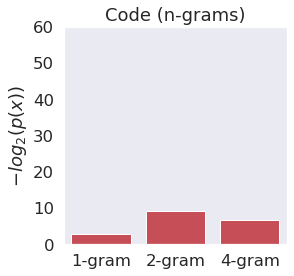

In [8]:
# MDL view of model parameters
# probability is converted to message length L in bits: L = -log_2(P)
bp = -np.log(pp) / np.log(2) # convert to bits (log_2)

# plotting defaults
sns.set_style("dark");
sns.despine();
cmap = sns.diverging_palette(10, 220, sep=80, n=2);
_ylim = 60
_ylabel = '$-log_{2}(p(x))$'
_figsize = (4,4)

fig = plt.figure(figsize=_figsize);
ax = sns.barplot(y=bp, x=names, color=cmap[0]);
ax.set_title('Code (n-grams)');
ax.set_ylabel(_ylabel);
ax.set_ylim(0,_ylim)

plot_name = 'code' + ext
# fig.savefig(os.path.join(Folder['Fig'], plot_name), bbox_inches = "tight")

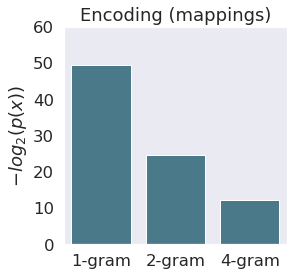

In [9]:
# (1) for every sequence in the set, find the shortest representation using chunks from the model
# (2) add individual sequence representations together to form a recoded set
# (3) measure the length of the recoding

%autoreload model
ll = [model.fit(Y, w) for w in W]
bl = -np.log(ll)  / np.log(2)

fig = plt.figure(figsize=_figsize);
ax = sns.barplot(y=bl, x=names, color=cmap[1])
ax.set_title('Encoding (mappings)');
ax.set_ylabel(_ylabel)
ax.set_ylim(0,_ylim)

plot_name = 'encoding' + ext
# fig.savefig(os.path.join(Folder['Fig'], plot_name), bbox_inches = "tight")

In [10]:
ax = model.plot_evi_bits(names, bp, bl, figsize=(4,4));
ax.set_ylim(0,_ylim)
ax.set_title('Model evidence');
ax.set_ylabel(_ylabel)

fig = ax.get_figure()
plot_name = 'evidence' + ext
# fig.savefig(os.path.join(Folder['Fig'], plot_name), bbox_inches = "tight")

### Model comparison over repetitions

In [11]:
seq_len = len(S[0])
# unigrams
w_uni = {(1,), (2,), (3,), (4,)}
# two four-grams
w_opt = {(3, 1, 4, 2), (2, 4, 1, 3), (1,), (2,), (3,), (4,)}
# four bi-grams
w_four = set(S)

names = ['1-gram', '4-gram', 'Optimal']

bits = lambda p : - np.log(p) / np.log(2)

L = pd.DataFrame(columns=['Repetition', 'Model', 'Fit', 'Evidence']) # dataframe for stats over reps

# sequences over trials
Y = [r for r in R for n in range(num_repeat)] # training set pre exp
T = [] # trials' set
[T.extend([N[i], R[0], R[1]]) for i in range(num_repeat)]

for i, y in enumerate(T):
    
    Y.append(y)
    
    W = [w_uni, set(Y), w_opt]
    tp = [model.prob_ngram(w, seq_len) for w in W]
    ll = [model.fit(Y, w) for w in W]  
    
    for j, l in enumerate(ll):
        L = L.append({'Repetition': i+1, 'Model': names[j], 'Fit': l, 
                      'Evidence': -(bits(tp[j]) + bits(l))}, ignore_index=True)

In [12]:
n = 12
xn = np.linspace(3, 36, n)
xt = np.array([['', '', str(xn[i])] for i in range(n)]).flatten()
Lr = L[L.Repetition.isin(xn)]

fig = plt.figure(figsize=(6,4));
ax = sns.pointplot(x="Repetition", y="Evidence", hue="Model", data=Lr, palette='husl', scale=0.4);
ax.legend(bbox_to_anchor=(0, 0.4), loc=2, borderaxespad=0, frameon=False);
ax.set_ylabel('Log model evidence')
ax.set_xlabel('Trials')
ax.set_title('Model evidence across trials');

plot_name = 'reps' + ext
# fig.savefig(os.path.join(Folder['Fig'], plot_name), bbox_inches = "tight")